In [4]:
import os
import random

# **Setting Up the Training and Testing Directories**

In [2]:
train_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
test_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'

# **Getting Data Ready**

In [3]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 validation_split=0.2,
                                                                 subset='training',
                                                                 seed=42,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 seed=42,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.
Found 22688 files belonging to 131 classes.


---
# **VISUALIZING DATA**

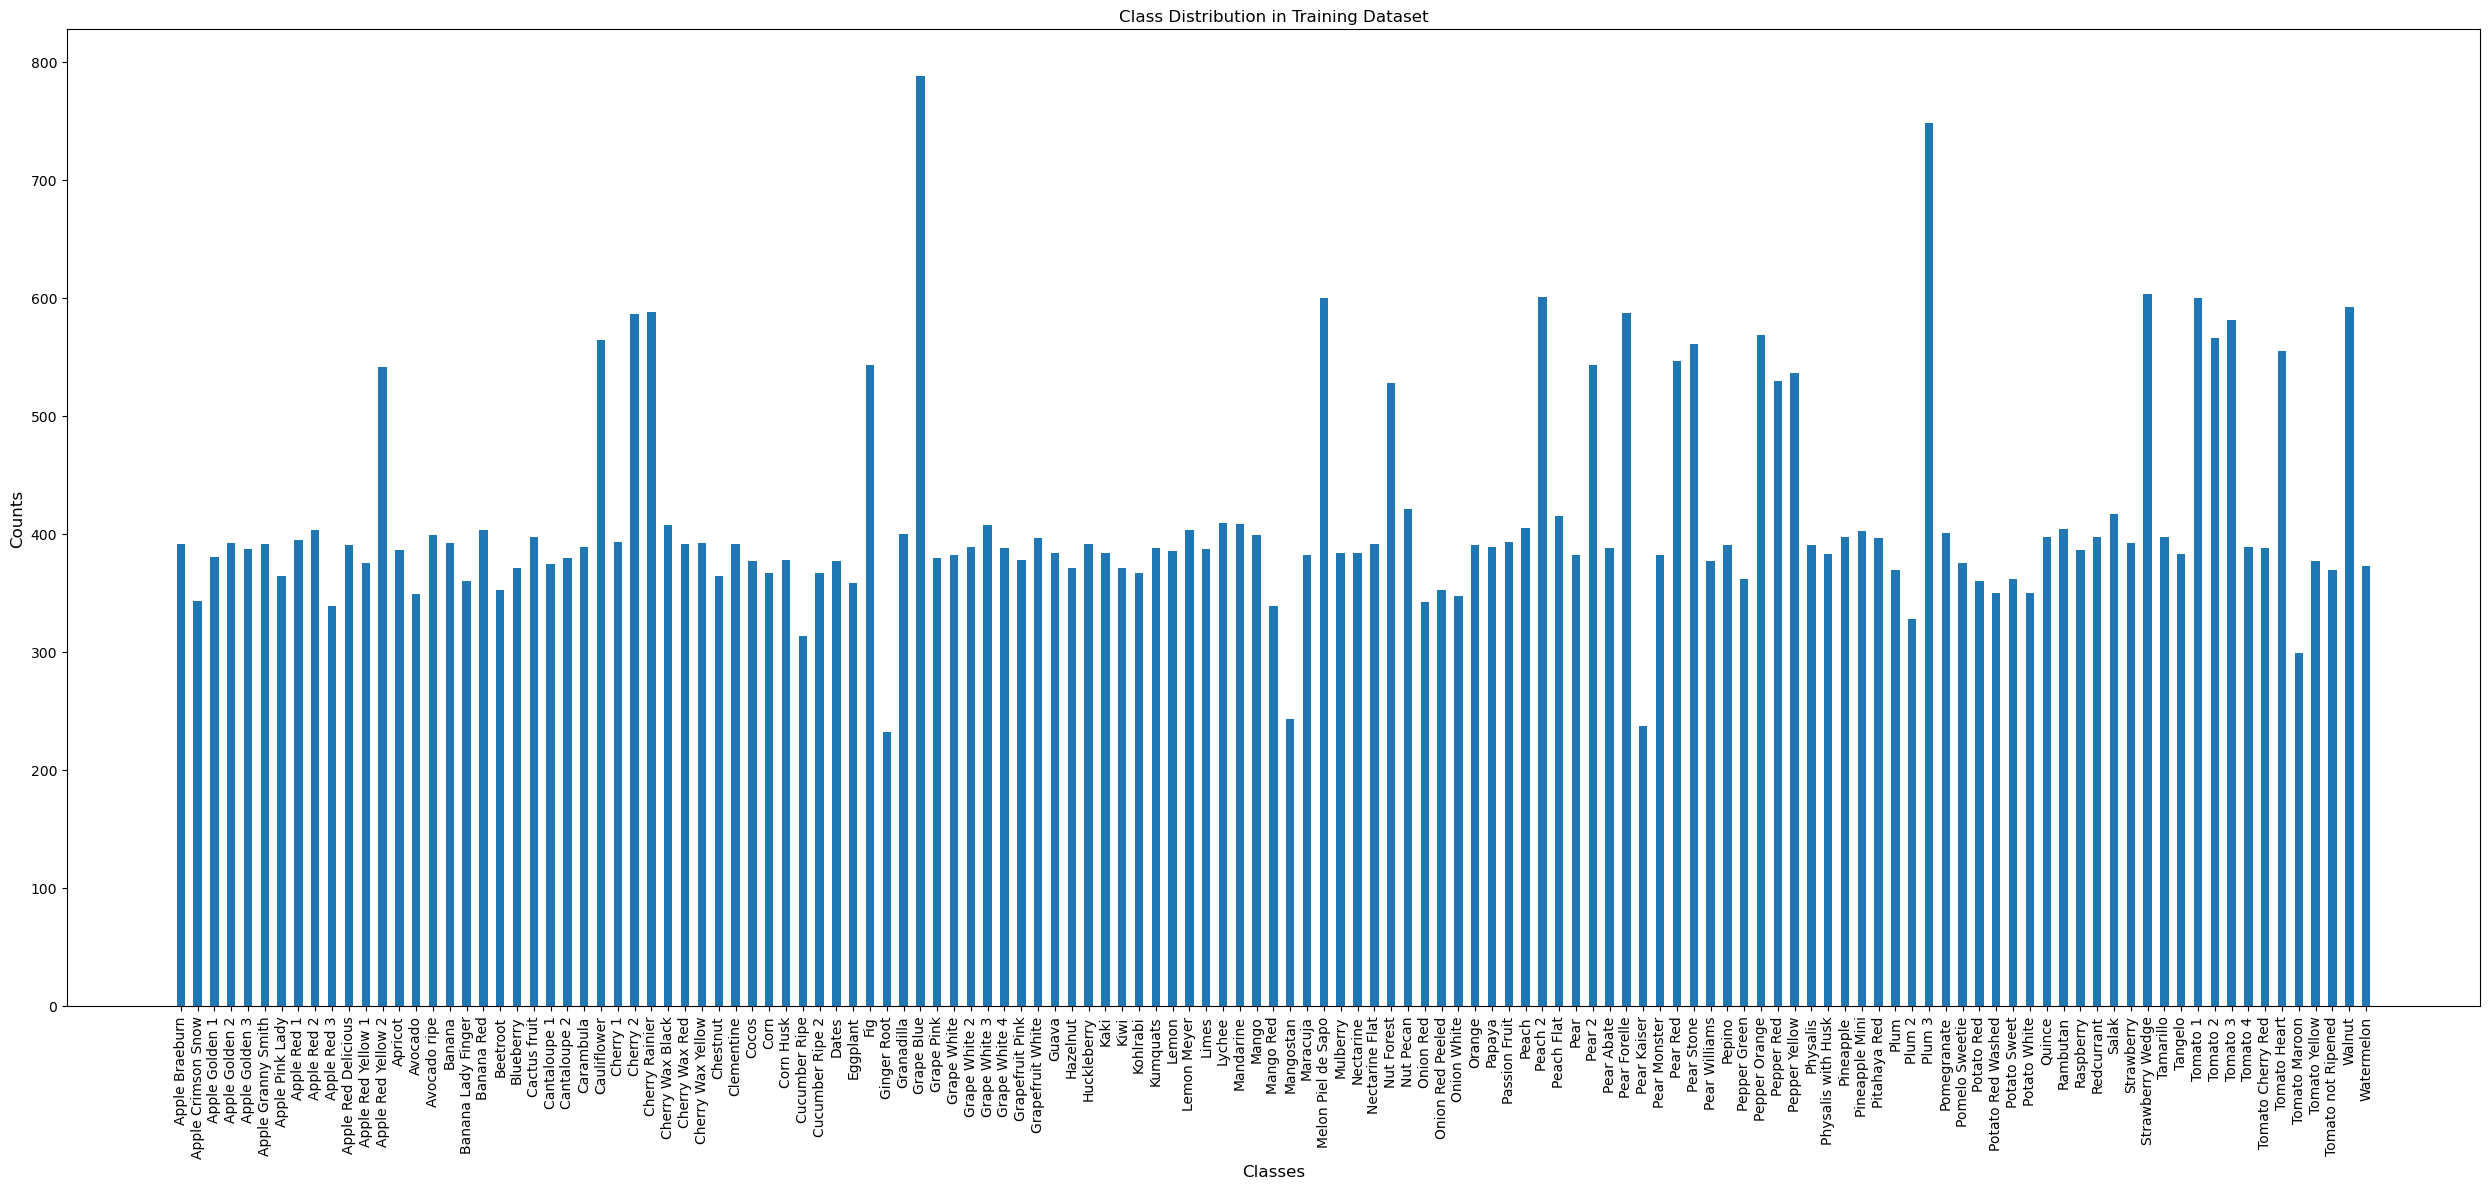

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class names from the dataset
class_names = train_data.class_names

# Count the occurrences of each class in the training dataset
train_labels = []
for images, labels in train_data:
    train_labels.extend(np.argmax(labels, axis=1))

class_counts = np.bincount(train_labels)


custom_space=0.5

# Create a bar plot
plt.figure(figsize=(25, 12))
plt.bar(class_names, class_counts, width=1.0 - custom_space)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


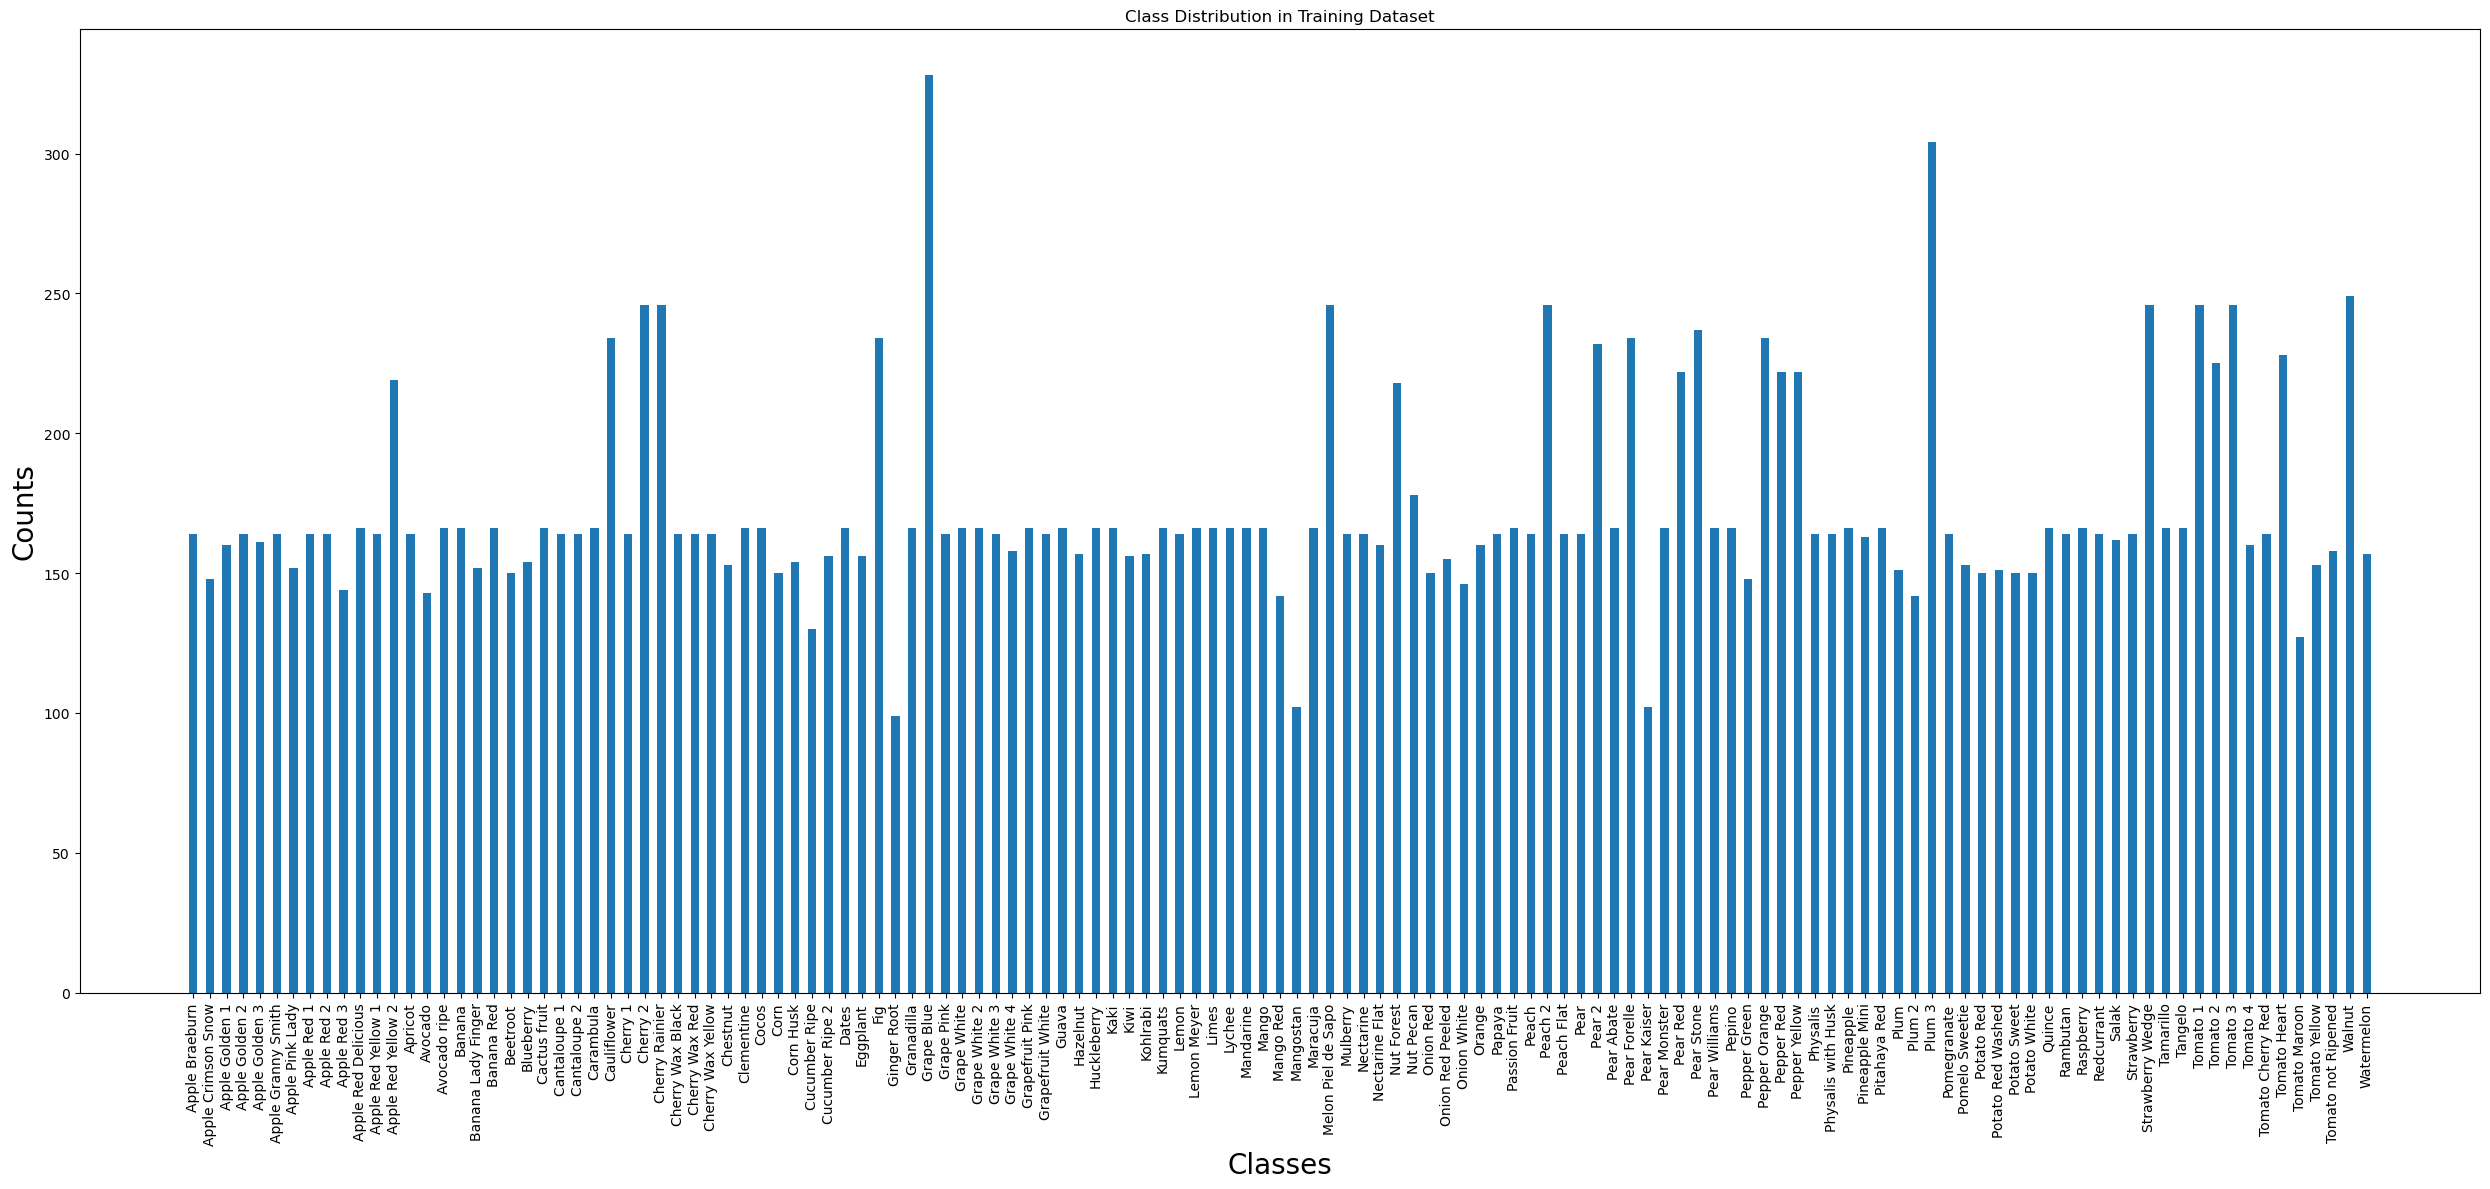

In [83]:
# Get the class names from the dataset
class_names = test_data.class_names

# Count the occurrences of each class in the training dataset
test_labels = []
for images, labels in test_data:
    test_labels.extend(np.argmax(labels, axis=1))

class_counts = np.bincount(test_labels)


custom_space=0.5

# Create a bar plot
plt.figure(figsize=(25, 12))
plt.bar(class_names, class_counts, width=1.0 - custom_space)
plt.xlabel('Classes', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# **Checkpoint**
---


In [4]:
checkpoint_path = 'fruits_classification_model_checkpoint.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

# **Data Augmentation**


In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1/255.)
],name='data_augmenation')

---
<h1><center><b> Model Building </b></center></h1> 

<table style="width:20%;">
  <tr>
    <th style="border: 1px solid black; border-radius: 10px;"><h2><center><b> Model Names </b></center></h2></th>
  </tr>
  <tr>
    <td style="border: 1px solid black; border-radius: 10px;"><h4><center><b> EfficientNetB3 </b></center></h4></td>
  </tr>
  <tr>
    <td style="border: 1px solid black; border-radius: 20px;"><h4><center><b> MobileNetV2 </b></center></h4></td>
  </tr>
  <tr>
    <td style="border: 1px solid black; border-radius: 10px;"><h4><center><b> VGG16 </b></center></h4></td>
  </tr>
</table>


---

<h5><center><b> EfficientNetB3 </b></center></h5>

In [6]:
base_model_1 = tf.keras.applications.EfficientNetB3(include_top=False)
base_model_1.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model_1(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
efficient_model = tf.keras.Model(inputs, outputs)

43941136/43941136 [==============================] - 3s 0us/step


In [7]:
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 131)               201347    
                                                                 
Total params: 10,984,882
Trainable params: 201,347
Non-traina

In [8]:
efficient_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

efficient_model_hist = efficient_model.fit(train_data,
                 epochs=10,
                 validation_data=valid_data,
                 validation_steps=len(valid_data)//BATCH_SIZE,
                 callbacks=[checkpoint_callback])

Epoch 1/10
1693/1693 [==============================] - 481s 273ms/step - loss: 4.9703 - accuracy: 0.0133 - val_loss: 5.2285 - val_accuracy: 0.0000e+00
Epoch 2/10
1693/1693 [==============================] - 401s 237ms/step - loss: 4.9266 - accuracy: 0.0166 - val_loss: 4.6984 - val_accuracy: 0.0000e+00
Epoch 3/10
1693/1693 [==============================] - 389s 230ms/step - loss: 4.9021 - accuracy: 0.0182 - val_loss: 5.3024 - val_accuracy: 0.0000e+00
Epoch 4/10
1693/1693 [==============================] - 381s 225ms/step - loss: 4.8785 - accuracy: 0.0201 - val_loss: 5.3183 - val_accuracy: 0.0000e+00
Epoch 5/10
1693/1693 [==============================] - 377s 223ms/step - loss: 4.8636 - accuracy: 0.0209 - val_loss: 4.9593 - val_accuracy: 0.0000e+00
Epoch 6/10
1693/1693 [==============================] - 377s 223ms/step - loss: 4.8479 - accuracy: 0.0206 - val_loss: 5.1342 - val_accuracy: 0.0000e+00
Epoch 7/10
1693/1693 [==============================] - 380s 224ms/step - loss: 4.8338 -

In [9]:
efficient_model_loss, efficient_model_acc = efficient_model.evaluate(test_data)

709/709 [==============================] - 83s 117ms/step - loss: 4.7832 - accuracy: 0.0107


<h5><center><b> MobileNetV2 </b></center></h5>

In [10]:
base_model_2 = tf.keras.applications.MobileNetV2(include_top=False)
base_model_2.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model_2(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
mobilenet_model = tf.keras.Model(inputs, outputs)

9406464/9406464 [==============================] - 1s 0us/step


In [11]:
mobilenet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 131)               167811    
                                                           

In [12]:
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


mobilenet_model_hist = mobilenet_model.fit(train_data,
                 epochs=10,
                 validation_data=valid_data,
                 validation_steps= len(valid_data)//BATCH_SIZE,
                 callbacks=[checkpoint_callback])

Epoch 1/10
1693/1693 [==============================] - 357s 207ms/step - loss: 0.4753 - accuracy: 0.9007 - val_loss: 0.7798 - val_accuracy: 0.7524
Epoch 2/10
1693/1693 [==============================] - 323s 191ms/step - loss: 0.0917 - accuracy: 0.9796 - val_loss: 0.1767 - val_accuracy: 0.9663
Epoch 3/10
1693/1693 [==============================] - 311s 184ms/step - loss: 0.0604 - accuracy: 0.9847 - val_loss: 0.0692 - val_accuracy: 0.9904
Epoch 4/10
1693/1693 [==============================] - 306s 181ms/step - loss: 0.0484 - accuracy: 0.9860 - val_loss: 0.2399 - val_accuracy: 0.9423
Epoch 5/10
1693/1693 [==============================] - 306s 181ms/step - loss: 0.0400 - accuracy: 0.9875 - val_loss: 0.0544 - val_accuracy: 0.9952
Epoch 6/10
1693/1693 [==============================] - 309s 183ms/step - loss: 0.0316 - accuracy: 0.9907 - val_loss: 0.0798 - val_accuracy: 0.9952
Epoch 7/10
1693/1693 [==============================] - 307s 181ms/step - loss: 0.0328 - accuracy: 0.9897 - val_

In [13]:
mobilenet_model_loss, mobilenet_model_acc = mobilenet_model.evaluate(test_data)

709/709 [==============================] - 34s 47ms/step - loss: 0.1574 - accuracy: 0.9549


<h5><center><b> VGG16 </b></center></h5>

In [14]:
base_model_3 = tf.keras.applications.VGG16(include_top=False)
base_model_3.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model_3(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
vgg16_model = tf.keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 3s 0us/step


In [15]:
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling (Glo  (None, 512)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 131)               67203     
                                                                 
Total params: 14,781,891
Trainable params: 67,203
Non-train

In [16]:
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


vgg16_model_hist = vgg16_model.fit(train_data,
                 epochs=10,
                 validation_data=valid_data,
                 validation_steps=len(valid_data)//BATCH_SIZE,
                 callbacks=[checkpoint_callback])

Epoch 1/10
1693/1693 [==============================] - 2534s 1s/step - loss: 3.5006 - accuracy: 0.3575 - val_loss: 3.9573 - val_accuracy: 0.2404
Epoch 2/10
1693/1693 [==============================] - 1441s 850ms/step - loss: 2.2347 - accuracy: 0.6516 - val_loss: 3.4247 - val_accuracy: 0.2596
Epoch 3/10
1693/1693 [==============================] - 1049s 619ms/step - loss: 1.6766 - accuracy: 0.7486 - val_loss: 3.0026 - val_accuracy: 0.2788
Epoch 4/10
1693/1693 [==============================] - 853s 503ms/step - loss: 1.3457 - accuracy: 0.8003 - val_loss: 2.7689 - val_accuracy: 0.2788
Epoch 5/10
1693/1693 [==============================] - 734s 433ms/step - loss: 1.1240 - accuracy: 0.8304 - val_loss: 2.3162 - val_accuracy: 0.3534
Epoch 6/10
1693/1693 [==============================] - 662s 390ms/step - loss: 0.9647 - accuracy: 0.8555 - val_loss: 2.1715 - val_accuracy: 0.3582
Epoch 7/10
1693/1693 [==============================] - 613s 361ms/step - loss: 0.8473 - accuracy: 0.8722 - val_

In [17]:
vgg16_model_loss, vgg16_model_acc = vgg16_model.evaluate(test_data)

709/709 [==============================] - 48s 67ms/step - loss: 0.8363 - accuracy: 0.8339


In [18]:
print("---------------------------------------------------------------------\n")

print("\t\t Training Loss  |  Training Accuracy ")

print("\nEfficientNetB3 :  {:.4} \t|\t {:.4}%".format(efficient_model_loss, efficient_model_acc*100))
print("\nMobileNetV2    :  {:.4} \t|\t {:.4}%".format(mobilenet_model_loss, mobilenet_model_acc*100))
print("\nVGG16          :  {:.4} \t|\t {:.4}%".format(vgg16_model_loss, vgg16_model_acc*100))

print("\n---------------------------------------------------------------------")

---------------------------------------------------------------------

		 Training Loss  |  Training Accuracy 

EfficientNetB3 :  4.783 	|	 1.067%

MobileNetV2    :  0.1574 	|	 95.49%

VGG16          :  0.8363 	|	 83.39%

---------------------------------------------------------------------


---

# **Hyperparameter Tuning**

We will be fine tunning both the models, we will be unfreezing the last 5 layers of base models.

<h5><center><b> EfficientNetB3 Fine Tune </b></center></h5>

In [19]:
# Unfreeze all of the layers in the base model
base_model_1.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model_1.layers[:-5]:
  layer.trainable = False

In [20]:
# Recompile model with lower learning rate
efficient_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [21]:
# What layers in the model are trainable?
for layer in efficient_model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmenation True
efficientnetb3 True
global_average_pooling True
output_layer True


In [40]:
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 131)               201347    
                                                                 
Total params: 10,984,882
Trainable params: 794,243
Non-traina

In [22]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling_1 False
2 normalization False
3 rescaling_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_reduce

In [23]:
# Fine-tune for 10 more epochs
fine_tune_epochs = 20 # model has already done 10 epochs, this is the total number of epochs we're after (10+10=20)

history_1 = efficient_model.fit(train_data,
                    epochs=fine_tune_epochs,
                    validation_data=valid_data,
                    validation_steps=len(valid_data)//BATCH_SIZE,
                    initial_epoch=efficient_model_hist.epoch[-1]) # start from previous last epoch

Epoch 10/20
1693/1693 [==============================] - 377s 214ms/step - loss: 4.6564 - accuracy: 0.0314 - val_loss: 4.6980 - val_accuracy: 0.0000e+00
Epoch 11/20
1693/1693 [==============================] - 364s 215ms/step - loss: 4.5895 - accuracy: 0.0356 - val_loss: 4.5337 - val_accuracy: 0.0000e+00
Epoch 12/20
1693/1693 [==============================] - 358s 211ms/step - loss: 4.5572 - accuracy: 0.0367 - val_loss: 4.4521 - val_accuracy: 0.0000e+00
Epoch 13/20
1693/1693 [==============================] - 366s 216ms/step - loss: 4.5160 - accuracy: 0.0411 - val_loss: 4.3112 - val_accuracy: 0.0000e+00
Epoch 14/20
1693/1693 [==============================] - 361s 213ms/step - loss: 4.4877 - accuracy: 0.0425 - val_loss: 4.4829 - val_accuracy: 0.0000e+00
Epoch 15/20
1693/1693 [==============================] - 360s 212ms/step - loss: 4.4461 - accuracy: 0.0454 - val_loss: 4.3209 - val_accuracy: 0.0000e+00
Epoch 16/20
1693/1693 [==============================] - 359s 212ms/step - loss: 4

In [24]:
efficient_model_fine_loss, efficient_model_fine_acc = efficient_model.evaluate(test_data)

709/709 [==============================] - 54s 76ms/step - loss: 4.2793 - accuracy: 0.0465


<h5><center><b> MobileNetV2 Fine Tune </b></center></h5>

In [25]:
# Unfreeze all of the layers in the base model
base_model_2.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model_2.layers[:-5]:
  layer.trainable = False

In [26]:
# Recompile model with lower learning rate
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [27]:
# What layers in the model are trainable?
for layer in mobilenet_model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmenation True
mobilenetv2_1.00_224 True
global_average_pooling True
output_layer True


In [41]:
mobilenet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 131)               167811    
                                                           

In [28]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [29]:
# Fine-tune for 10 more epochs
fine_tune_epochs = 20 # model has already done 10 epochs, this is the total number of epochs we're after (10+10=20)

history_2 = mobilenet_model.fit(train_data,
                    epochs=fine_tune_epochs,
                    validation_data=valid_data,
                    validation_steps=len(valid_data)//BATCH_SIZE,
                    initial_epoch=mobilenet_model_hist.epoch[-1]) # start from previous last epoch

Epoch 10/20
1693/1693 [==============================] - 303s 175ms/step - loss: 0.0844 - accuracy: 0.9740 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 11/20
1693/1693 [==============================] - 295s 174ms/step - loss: 0.0566 - accuracy: 0.9816 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 12/20
1693/1693 [==============================] - 295s 174ms/step - loss: 0.0518 - accuracy: 0.9836 - val_loss: 0.0908 - val_accuracy: 0.9543
Epoch 13/20
1693/1693 [==============================] - 294s 174ms/step - loss: 0.0419 - accuracy: 0.9866 - val_loss: 0.0485 - val_accuracy: 0.9808
Epoch 14/20
1693/1693 [==============================] - 293s 173ms/step - loss: 0.0397 - accuracy: 0.9869 - val_loss: 0.0350 - val_accuracy: 0.9952
Epoch 15/20
1693/1693 [==============================] - 295s 174ms/step - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.0190 - val_accuracy: 0.9928
Epoch 16/20
1693/1693 [==============================] - 294s 174ms/step - loss: 0.0305 - accuracy: 0.9904

In [39]:
mobilenet_model_fine_loss, mobilenet_model_fine_acc = mobilenet_model.evaluate(test_data)

709/709 [==============================] - 27s 38ms/step - loss: 0.1742 - accuracy: 0.9560


<h5><center><b> VGG16 Fine Tune </b></center></h5>

In [31]:
# Unfreeze all of the layers in the base model
base_model_3.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model_3.layers[:-5]:
  layer.trainable = False

In [32]:
# Recompile model with lower learning rate
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [33]:
# What layers in the model are trainable?
for layer in vgg16_model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmenation True
vgg16 True
global_average_pooling True
output_layer True


In [42]:
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling (Glo  (None, 512)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 131)               67203     
                                                                 
Total params: 14,781,891
Trainable params: 7,146,627
Non-tr

In [34]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_3.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [35]:
# Fine-tune for 10 more epochs
fine_tune_epochs = 20 # model has already done 10 epochs, this is the total number of epochs we're after (10+10=20)

history_3 = vgg16_model.fit(train_data,
                    epochs=fine_tune_epochs,
                    validation_data=valid_data,
                    validation_steps=len(valid_data)//BATCH_SIZE,
                    initial_epoch=mobilenet_model_hist.epoch[-1]) # start from previous last epoch

Epoch 10/20
1693/1693 [==============================] - 469s 274ms/step - loss: 0.1691 - accuracy: 0.9463 - val_loss: 0.2185 - val_accuracy: 0.9279
Epoch 11/20
1693/1693 [==============================] - 443s 262ms/step - loss: 0.0604 - accuracy: 0.9806 - val_loss: 0.0287 - val_accuracy: 0.9904
Epoch 12/20
1693/1693 [==============================] - 426s 252ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.0202 - val_accuracy: 0.9976
Epoch 13/20
1693/1693 [==============================] - 416s 245ms/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 14/20
1693/1693 [==============================] - 409s 241ms/step - loss: 0.0380 - accuracy: 0.9890 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 15/20
1693/1693 [==============================] - 402s 237ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 16/20
1693/1693 [==============================] - 395s 233ms/step - loss: 0.0228 - accuracy: 0.9931

In [36]:
vgg16_model_fine_loss, vgg16_model_fine_acc = vgg16_model.evaluate(test_data)

709/709 [==============================] - 48s 67ms/step - loss: 0.0822 - accuracy: 0.9818


In [37]:
print("---------------------------------------------------------------------\n")
print("\t\t Training Loss  |  Training Accuracy ")

print("\nEfficientNetB3 :  {:.4} \t|\t {:.4}%".format(efficient_model_fine_loss, efficient_model_fine_acc*100))
print("\nMobileNetV2    :  {:.4} \t|\t {:.4}%".format(mobilenet_model_fine_loss, mobilenet_model_fine_acc*100))
print("\nVGG16          :  {:.4} \t|\t {:.4}%".format(vgg16_model_fine_loss, vgg16_model_fine_acc*100))

print("\n---------------------------------------------------------------------")

---------------------------------------------------------------------

		 Training Loss  |  Training Accuracy 

EfficientNetB3 :  4.279 	|	 4.654%

MobileNetV2    :  0.1742 	|	 95.6%

VGG16          :  0.08217 	|	 98.18%

---------------------------------------------------------------------


---

# **Plotting The Models' Accuracy and Loss**

<AxesSubplot:title={'center':'VGG16-FineTuned'}, xlabel='Epochs', ylabel='Accuracy'>

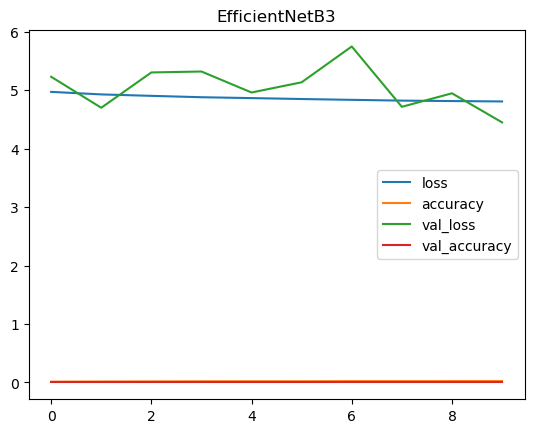

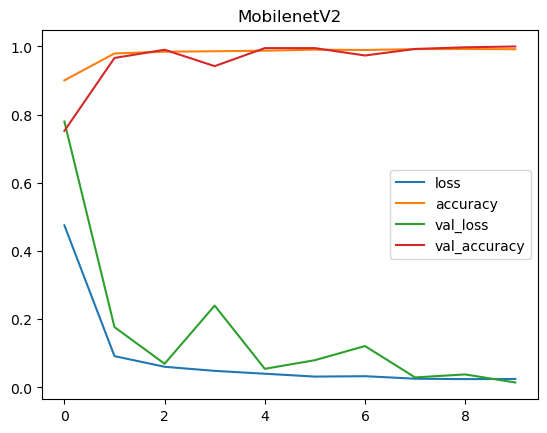

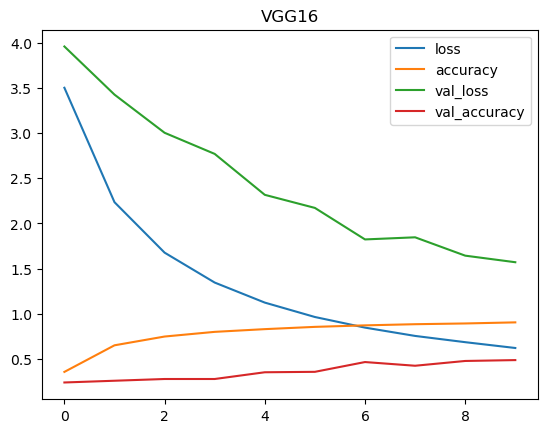

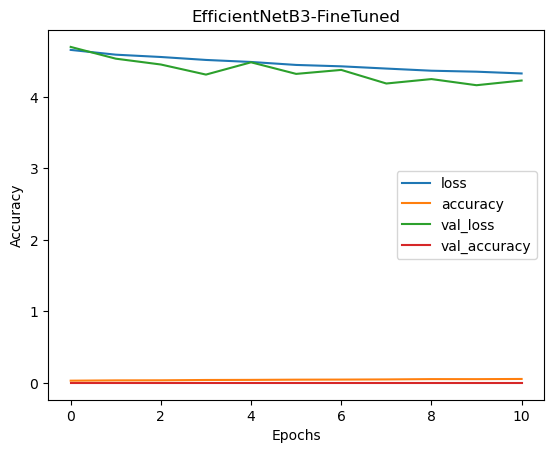

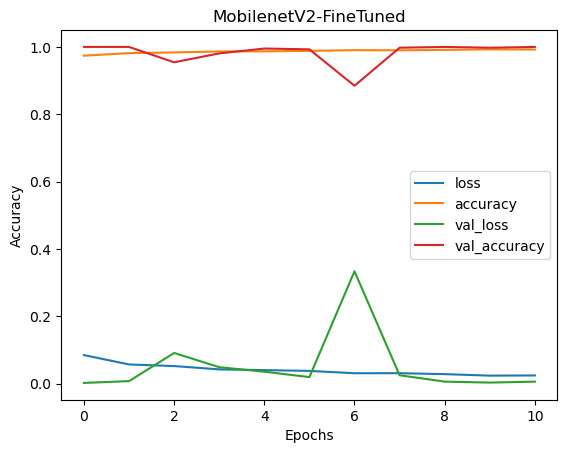

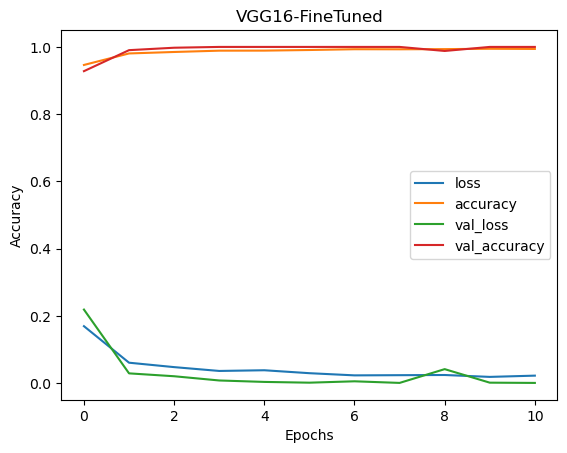

In [43]:
import pandas as pd
hist_1 = pd.DataFrame(efficient_model_hist.history)
hist_2 = pd.DataFrame(mobilenet_model_hist.history)
hist_3 = pd.DataFrame(vgg16_model_hist.history)

hist_4 = pd.DataFrame(history_1.history)
hist_5 = pd.DataFrame(history_2.history)
hist_6 = pd.DataFrame(history_3.history)


hist_1.plot(title='EfficientNetB3')
hist_2.plot(title='MobilenetV2')
hist_3.plot(title='VGG16')

hist_4.plot(xlabel='Epochs', ylabel='Accuracy', title='EfficientNetB3-FineTuned')
hist_5.plot(xlabel='Epochs', ylabel='Accuracy', title='MobilenetV2-FineTuned')
hist_6.plot(xlabel='Epochs', ylabel='Accuracy', title='VGG16-FineTuned')

# **Making Predictions**
---
As per the model-performace's before and after the best performed model was VGG16. So we will be making predicitons using the Fine-Tuned MobilenetV2.

In [44]:
pred_probs = vgg16_model.predict(test_data, verbose=1)

709/709 [==============================] - 45s 63ms/step


In [45]:
print(len(pred_probs)) 
print(pred_probs.shape)

22688
(22688, 131)


In [46]:
pred_probs[:10]

array([[9.9999726e-01, 1.2825429e-16, 2.2564205e-21, ..., 8.5143738e-29,
        1.2740891e-28, 0.0000000e+00],
       [9.9999642e-01, 1.0869853e-16, 8.4739898e-22, ..., 1.0647145e-29,
        3.3409709e-29, 0.0000000e+00],
       [9.9999714e-01, 1.6216632e-16, 6.2492869e-22, ..., 1.6173156e-29,
        6.4178227e-29, 0.0000000e+00],
       ...,
       [9.9999499e-01, 2.3214388e-14, 1.0006574e-18, ..., 2.8547036e-30,
        9.1044719e-30, 0.0000000e+00],
       [9.9999952e-01, 1.4354185e-13, 2.0833381e-20, ..., 7.0045199e-30,
        2.4464223e-29, 0.0000000e+00],
       [9.9999917e-01, 9.8859865e-14, 6.9664473e-20, ..., 3.5600923e-29,
        1.8288912e-29, 0.0000000e+00]], dtype=float32)

In [47]:
print(f'sample 0 :-> {len(pred_probs[0])}')
print(f'prediciton probability for sample 0 :-> {pred_probs[0]}')
print(f'class for sample 0 :-> {pred_probs[0].argmax()}')

sample 0 :-> 131
prediciton probability for sample 0 :-> [9.9999726e-01 1.2825429e-16 2.2564205e-21 1.6179132e-23 1.7788760e-16
 7.1604006e-19 1.2122710e-13 1.4782083e-10 2.4287569e-06 8.8666992e-13
 7.3728960e-24 6.7395837e-15 1.5118012e-20 1.4516232e-14 6.6181044e-24
 1.9424279e-28 8.8617272e-36 2.0820981e-31 1.0928230e-32 8.7255921e-31
 2.2224298e-36 2.7944928e-29 0.0000000e+00 0.0000000e+00 7.0542022e-27
 0.0000000e+00 7.7373303e-21 2.1521605e-24 8.7062613e-34 2.5043943e-36
 2.3451949e-30 0.0000000e+00 1.4381279e-17 2.6823272e-21 5.6700404e-30
 0.0000000e+00 0.0000000e+00 1.5452125e-25 1.3859590e-19 4.0583262e-35
 2.3304111e-28 3.2775249e-31 0.0000000e+00 6.9492041e-21 6.3792391e-35
 1.8341542e-08 0.0000000e+00 0.0000000e+00 1.3291836e-32 1.4789137e-32
 6.4719173e-27 1.3717753e-23 8.1497035e-30 1.4019270e-34 0.0000000e+00
 3.1575964e-24 8.6402401e-30 3.4969659e-25 9.3384978e-26 1.1833008e-18
 3.0641793e-28 1.5943883e-35 9.5806604e-32 1.3859490e-33 4.6980006e-27
 4.3844181e-19 1.341

In [48]:
pred_classes = pred_probs.argmax(axis=1)

In [49]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
len(y_labels)

22688

In [51]:
class_names = test_data.class_names
class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       164
           1       0.74      0.86      0.79       148
           2       1.00      1.00      1.00       160
           3       1.00      1.00      1.00       164
           4       0.89      1.00      0.94       161
           5       1.00      0.88      0.94       164
           6       0.87      1.00      0.93       152
           7       1.00      1.00      1.00       164
           8       1.00      0.85      0.92       164
           9       0.99      1.00      0.99       144
          10       1.00      1.00      1.00       166
          11       1.00      1.00      1.00       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       1.00      1.00      1.00       143
          15       0.98      1.00      0.99       166
          16       1.00      1.00      1.00       166
          17       0.93    

In [53]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.8961748633879781,
  'recall': 1.0,
  'f1-score': 0.9452449567723342,
  'support': 164},
 '1': {'precision': 0.7383720930232558,
  'recall': 0.8581081081081081,
  'f1-score': 0.7937500000000001,
  'support': 148},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 160},
 '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 164},
 '4': {'precision': 0.8895027624309392,
  'recall': 1.0,
  'f1-score': 0.9415204678362573,
  'support': 161},
 '5': {'precision': 1.0,
  'recall': 0.8780487804878049,
  'f1-score': 0.9350649350649352,
  'support': 164},
 '6': {'precision': 0.8685714285714285,
  'recall': 1.0,
  'f1-score': 0.9296636085626911,
  'support': 152},
 '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 164},
 '8': {'precision': 1.0,
  'recall': 0.8536585365853658,
  'f1-score': 0.9210526315789475,
  'support': 164},
 '9': {'precision': 0.9863013698630136,
  'recall': 1.0,
  'f1-score': 0.993103448275862,
  'support': 

In [54]:
def load_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape,img_shape])
  if scale:
    return img/255.
  else:
    return img

In [55]:
load_prep_image('/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test/Apple Golden 1/105_100.jpg')

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)>

---
# **Plotting Those Predictions**

1/1 [==============================] - 0s 25ms/step


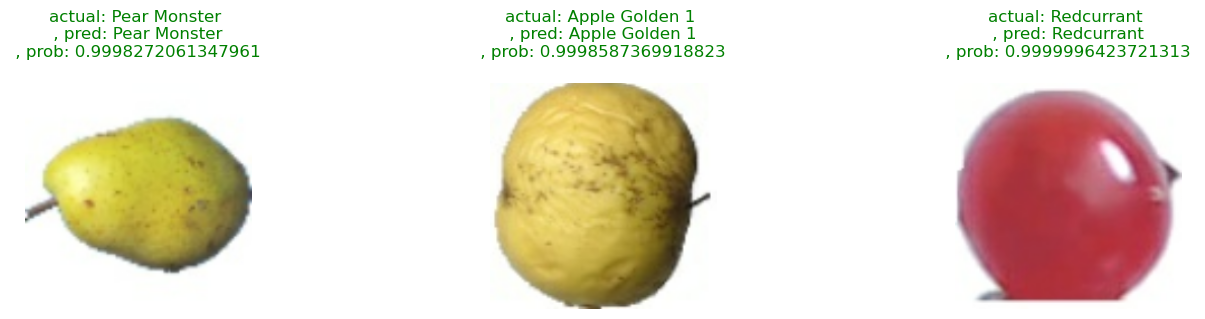

In [64]:
import os
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = load_prep_image(filepath,scale=False)
  pred_prob = mobilenet_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(3,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f'actual: {class_name} \n , pred: {pred_class} \n , prob: {pred_prob.max()} \n ',c=title_color)
  plt.axis(False)


1/1 [==============================] - 0s 25ms/step


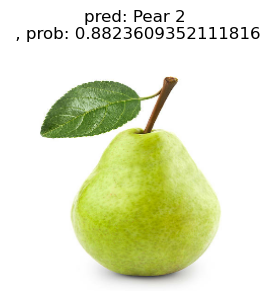

In [95]:
import os
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(17,10))

def RealTimePred(filepath):
    img = load_prep_image(filepath,scale=False)
    pred_prob = mobilenet_model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(3,3,i+1)
    plt.imshow(img/255.)
    
    plt.title(f'pred: {pred_class} \n , prob: {pred_prob.max()} \n ')
    plt.axis(False)
    
RealTimePred("/kaggle/input/pear-ss/istockphoto-529401513-612x612.jpg")

---
<h2><center><b> Model Architecture </b></center></h2>

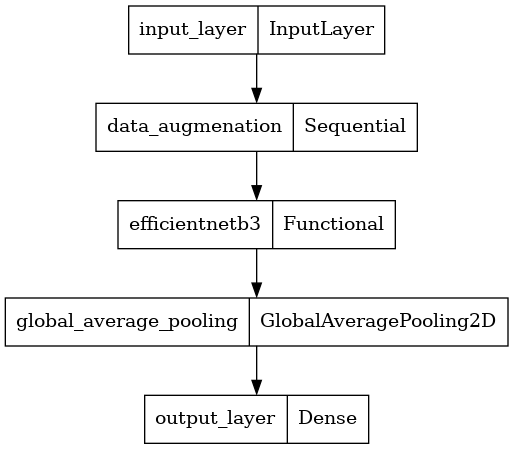

In [75]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
efficient_model, to_file='e_model.png',
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

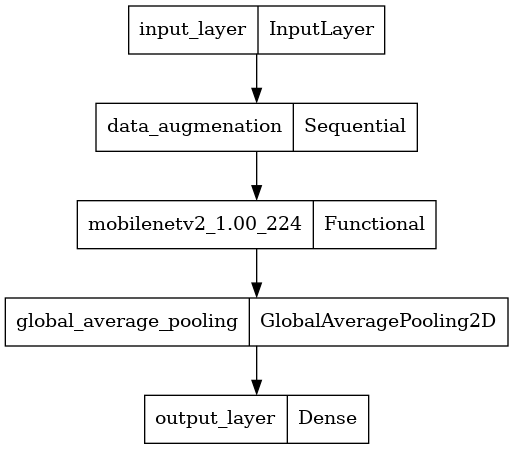

In [76]:
tf.keras.utils.plot_model(
mobilenet_model, to_file='m_model.png',
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

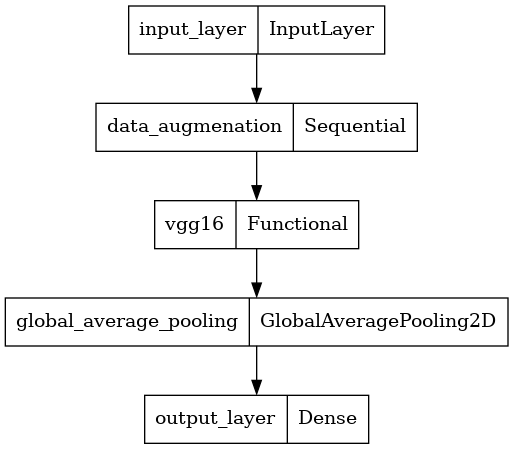

In [77]:
tf.keras.utils.plot_model(
vgg16_model, to_file='v_model.png',
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

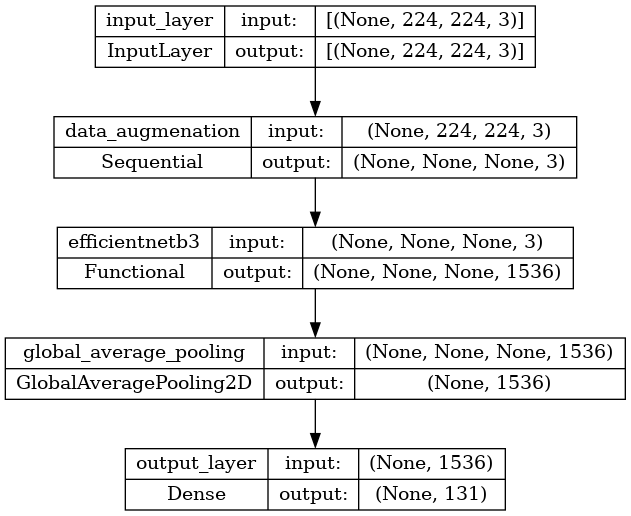

In [78]:
tf.keras.utils.plot_model(
efficient_model, to_file='es_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

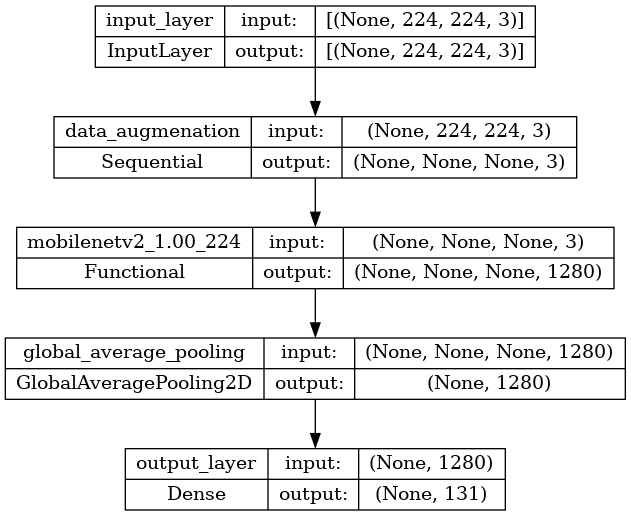

In [79]:
tf.keras.utils.plot_model(
mobilenet_model, to_file='ms_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

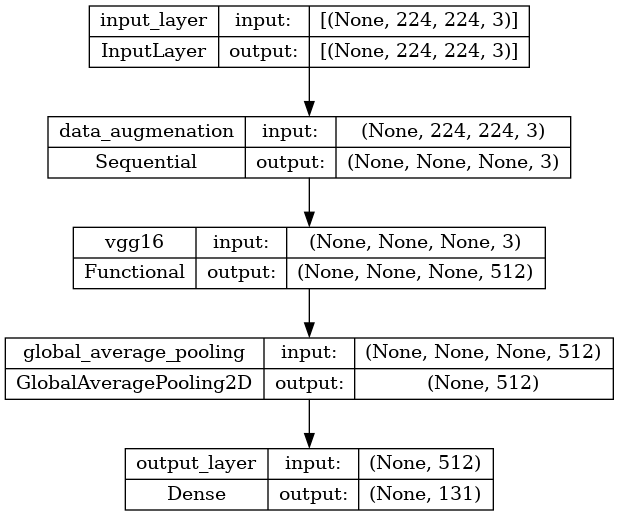

In [80]:
tf.keras.utils.plot_model(
vgg16_model, to_file='vs_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [81]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_labels, pred_classes)

# Print the confusion matrix
print(cm)

[[164   0   0 ...   0   0   0]
 [  0 127   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]


-----
-----

<h1><center><b> ROTTEN FRUIT CLASSIFICATION </b></center></h1>

-----
-----

We need to Classify whether a fruit is rotten or not.

The input is a Still Image.

The output is the result: **Fresh or Rotten**, we can also classify this as binary with 1 - Fresh and 0 - Rotten.

From going over our dataset, we see fruits (***apples, banans and oranges***), rotten and fresh in different folders representing each.

# **Getting Data Ready**

We want to make a slight variation on the data.

Instead of 6 categories (fresh - apple, banana, orange | rotten - apple, banana, orange)

We want to have 2 categories (fresh | rotten)

So we're rearranging the folders accordingly

In [5]:
from distutils.dir_util import copy_tree

train_folder_rc = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train'
test_folder_rc = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test'

# Make a new train folder with fresh fruits
toDirectory = '/kaggle/working/train/freshfruits';

fromDirectory = train_folder_rc + '/freshapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder_rc + '/freshbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder_rc + '/freshoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new train folder with rotten fruits
toDirectory = '/kaggle/working/train/rottenfruits';

fromDirectory = train_folder_rc + '/rottenapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder_rc + '/rottenbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder_rc + '/rottenoranges';
copy_tree(fromDirectory, toDirectory);


# Make a new test folder with fresh fruits
toDirectory = '/kaggle/working/test/freshfruits';

fromDirectory = test_folder_rc + '/freshapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder_rc + '/freshbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder_rc + '/freshoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new test folder with rotten fruits
toDirectory = '/kaggle/working/test/rottenfruits';

fromDirectory = test_folder_rc + '/rottenapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder_rc + '/rottenbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder_rc + '/rottenoranges';
copy_tree(fromDirectory, toDirectory);

In [6]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_rc = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/working/train/',
                                                                 validation_split=0.2,
                                                                 seed=42,
                                                                 subset='training',
                                                                 label_mode='binary',
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='rgb')

valid_data_rc = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/working/train/',
                                                                 validation_split=0.2,
                                                                 seed=42,
                                                                 subset='validation',
                                                                 label_mode='binary',
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='rgb')

test_data_rc = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/working/test/',
                                                                 label_mode='binary',
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='rgb')


Found 10901 files belonging to 2 classes.
Using 8721 files for training.
Found 10901 files belonging to 2 classes.
Using 2180 files for validation.
Found 2698 files belonging to 2 classes.


# **VISUALIZING DATA**
---

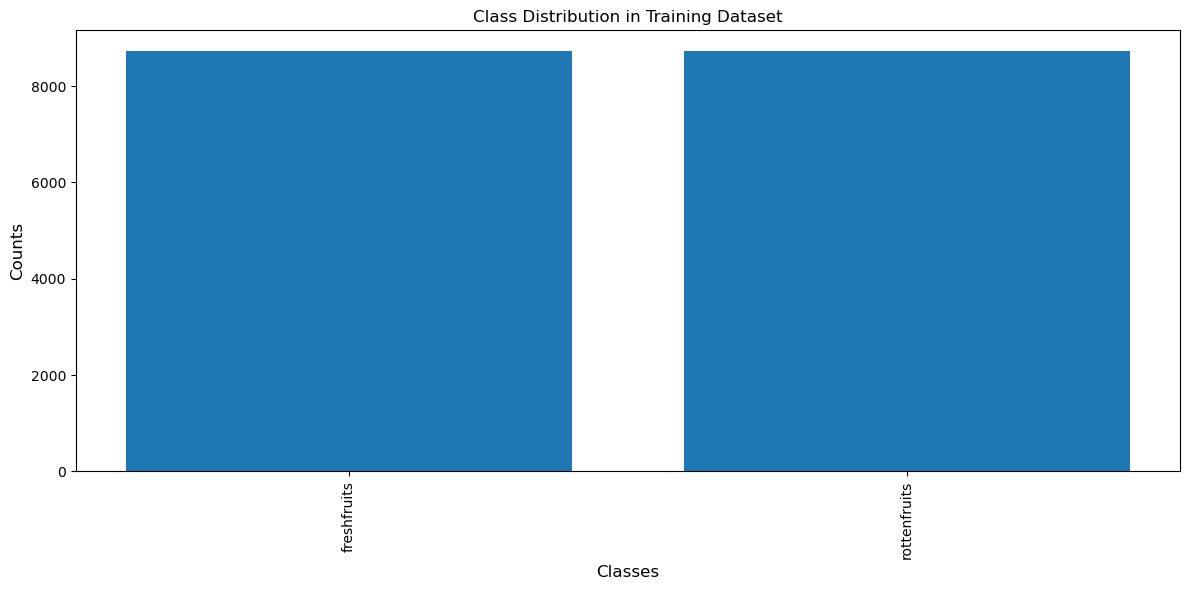

In [7]:
# Get the class names from the dataset
class_names_rc = train_data_rc.class_names

# Count the occurrences of each class in the training dataset
train_labels_rc = []
for images, labels in train_data_rc:
    train_labels_rc.extend(np.argmax(labels, axis=1))

class_counts_rc = np.bincount(train_labels_rc)


# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(class_names_rc, class_counts_rc)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


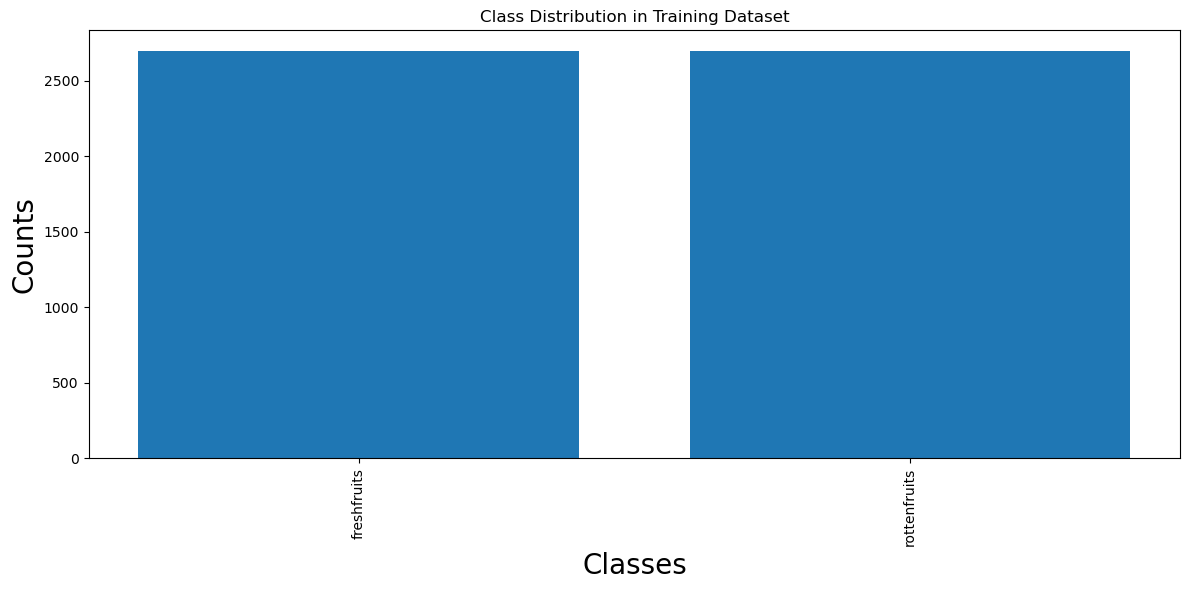

In [8]:
# Get the class names from the dataset
class_names_rc = test_data_rc.class_names

# Count the occurrences of each class in the training dataset
test_labels_rc = []
for images, labels in test_data_rc:
    test_labels_rc.extend(np.argmax(labels, axis=1))

class_counts_rc = np.bincount(test_labels_rc)


# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(class_names_rc, class_counts_rc)
plt.xlabel('Classes', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



<h3><center><b> Function to show an image and its size </b></center></h3>

In [9]:
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

(374, 400, 4)


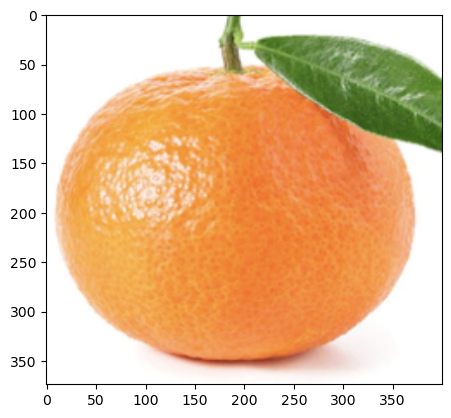

In [10]:
#Fresh Example:
show_image("/kaggle/working/train/freshfruits/Screen Shot 2018-06-12 at 11.52.03 PM.png")

(308, 310, 4)


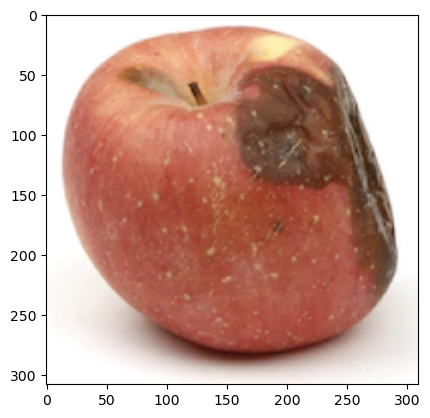

In [11]:
#Rotten example:
show_image('/kaggle/working/train/rottenfruits/Screen Shot 2018-06-07 at 2.33.38 PM.png')

# **Checkpoint**
---


In [12]:
checkpoint_path = 'rotten_fruits_classification_model_checkpoint.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

---

---

# **Model Building**
---

AS WE ALREADY HAVE SEEN THAT THE MODEL VGG16 PERFORMED WELL. SO WE'RE USING THAT HERE TOO FOR THE ROTTEN CLASSIFICATION. BUT WE'LL BE CHANGING SOME PARTS IN THE MODEL.

Here we will add one unit output layer - as we want to make a binary classification just a sigmoid basically.

In [13]:
base_model_4 = tf.keras.applications.VGG16(include_top=False)

base_model_4.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model_4(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
vgg16_rc_model = tf.keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 3s 0us/step


In [14]:
vgg16_rc_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling (Glo  (None, 512)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable 

As this is a binary (0 | 1) problem so we choose the BinaryCrossentropy in the Compile Method.

In [15]:
vgg16_rc_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])


vgg16_rc_model_hist = vgg16_rc_model.fit(train_data_rc,
                 epochs=10,
                 validation_data=valid_data_rc,
                 callbacks=[checkpoint_callback])

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


273/273 [==============================] - 671s 2s/step - loss: 0.5701 - binary_accuracy: 0.7441 - val_loss: 0.4672 - val_binary_accuracy: 0.8514
Epoch 2/10
273/273 [==============================] - 484s 2s/step - loss: 0.4180 - binary_accuracy: 0.8517 - val_loss: 0.3819 - val_binary_accuracy: 0.8693
Epoch 3/10
273/273 [==============================] - 419s 2s/step - loss: 0.3628 - binary_accuracy: 0.8652 - val_loss: 0.3363 - val_binary_accuracy: 0.8881
Epoch 4/10
273/273 [==============================] - 376s 1s/step - loss: 0.3216 - binary_accuracy: 0.8807 - val_loss: 0.3034 - val_binary_accuracy: 0.9028
Epoch 5/10
273/273 [==============================] - 322s 1s/step - loss: 0.3011 - binary_accuracy: 0.8891 - val_loss: 0.2817 - val_binary_accuracy: 0.9073
Epoch 6/10
273/273 [==============================] - 326s 1s/step - loss: 0.2830 - binary_accuracy: 0.8952 - val_loss: 0.2640 - val_binary_accuracy: 0.9119
Epoch 7/10
273/273 [==============================] - 285s 1s/step - 

In [16]:
vgg16_rc_model_loss, vgg16_rc_model_acc = vgg16_rc_model.evaluate(test_data_rc)

85/85 [==============================] - 10s 107ms/step - loss: 0.2124 - binary_accuracy: 0.9299


In [17]:
print("---------------------------------------------------------------------\n")

print("\t\t Training Loss  |  Training Accuracy ")

print("\nMobileNetV2    :  {:.4} \t|\t {:.4}%".format(vgg16_rc_model_loss, vgg16_rc_model_acc*100))

print("\n---------------------------------------------------------------------")

---------------------------------------------------------------------

		 Training Loss  |  Training Accuracy 

MobileNetV2    :  0.2124 	|	 92.99%

---------------------------------------------------------------------


---
# **Hyperparameter Tuning**

We will be fine tunning both the models, we will be unfreezing the last 5 layers of base models.

In [18]:
# Unfreeze all of the layers in the base model
base_model_4.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model_4.layers[:-5]:
  layer.trainable = False

In [19]:
# Recompile model with lower learning rate
vgg16_rc_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [20]:
# What layers in the model are trainable?
for layer in vgg16_rc_model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmenation True
vgg16 True
global_average_pooling True
output_layer True


In [21]:
vgg16_rc_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling (Glo  (None, 512)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 7,079,937
Non-trai

In [22]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_4.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [23]:
# Fine-tune for 10 more epochs
fine_tune_epochs = 20 # model has already done 10 epochs, this is the total number of epochs we're after (10+10=20)

history_4 = vgg16_rc_model.fit(train_data_rc,
                    epochs=fine_tune_epochs,
                    validation_data=valid_data_rc,
                    initial_epoch=vgg16_rc_model_hist.epoch[-1]) # start from previous last epoch

Epoch 10/20
273/273 [==============================] - 239s 853ms/step - loss: 0.1136 - binary_accuracy: 0.9569 - val_loss: 0.0505 - val_binary_accuracy: 0.9826
Epoch 11/20
273/273 [==============================] - 232s 848ms/step - loss: 0.0478 - binary_accuracy: 0.9831 - val_loss: 0.0505 - val_binary_accuracy: 0.9794
Epoch 12/20
273/273 [==============================] - 210s 766ms/step - loss: 0.0307 - binary_accuracy: 0.9906 - val_loss: 0.0321 - val_binary_accuracy: 0.9894
Epoch 13/20
273/273 [==============================] - 191s 699ms/step - loss: 0.0192 - binary_accuracy: 0.9936 - val_loss: 0.0200 - val_binary_accuracy: 0.9922
Epoch 14/20
273/273 [==============================] - 212s 776ms/step - loss: 0.0146 - binary_accuracy: 0.9955 - val_loss: 0.0151 - val_binary_accuracy: 0.9945
Epoch 15/20
273/273 [==============================] - 197s 713ms/step - loss: 0.0270 - binary_accuracy: 0.9906 - val_loss: 0.0240 - val_binary_accuracy: 0.9913
Epoch 16/20
273/273 [=============

In [24]:
vgg16_rc_model_fine_loss, vgg16_rc_model_fine_acc = vgg16_rc_model.evaluate(test_data_rc)

85/85 [==============================] - 9s 93ms/step - loss: 0.0324 - binary_accuracy: 0.9885


In [25]:
print("---------------------------------------------------------------------\n")
print("\t\t Training Loss  |  Training Accuracy ")

print("\nMobileNetV2    :  {:.4} \t|\t {:.4}%".format(vgg16_rc_model_fine_loss, vgg16_rc_model_fine_acc*100))

print("\n---------------------------------------------------------------------")

---------------------------------------------------------------------

		 Training Loss  |  Training Accuracy 

MobileNetV2    :  0.03244 	|	 98.85%

---------------------------------------------------------------------


---
<h3><center><b> PLOTTING THE GRAPHS </b></center></h3>

---

<AxesSubplot:title={'center':'VGG16-FineTuned'}, xlabel='Epochs', ylabel='Accuracy'>

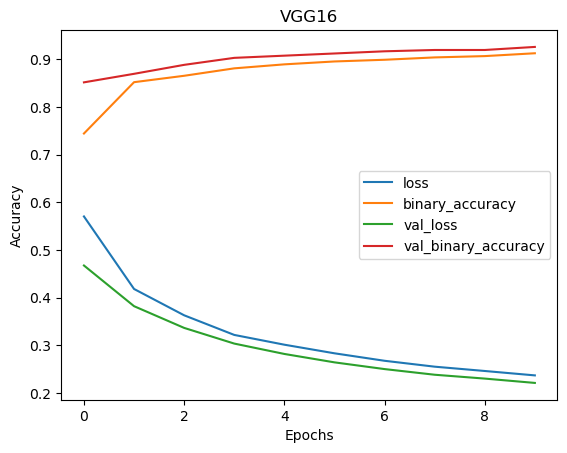

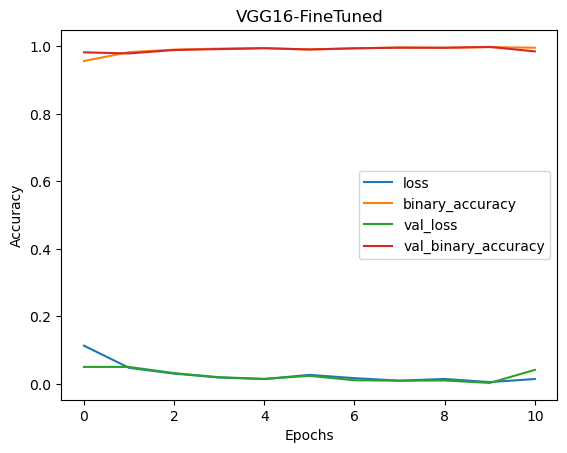

In [26]:
hist_7 = pd.DataFrame(vgg16_rc_model_hist.history)

hist_8 = pd.DataFrame(history_4.history)


hist_7.plot(xlabel='Epochs', ylabel='Accuracy', title='VGG16')

hist_8.plot(xlabel='Epochs', ylabel='Accuracy', title='VGG16-FineTuned')

# **Making Predictions**
---

In [27]:

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = vgg16_rc_model.predict(image)
    return preds

(336, 354, 4)
1/1 [==============================] - 0s 434ms/step


array([[4.21565e-05]], dtype=float32)

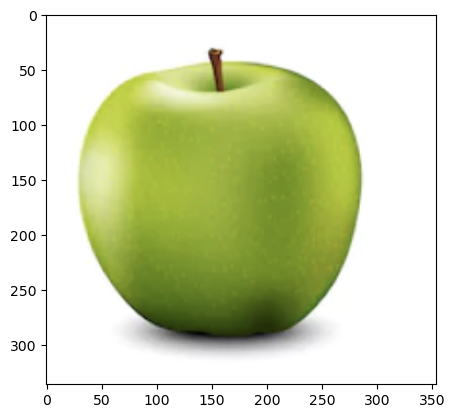

In [28]:
make_predictions('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.04.16 PM.png')


(356, 478, 4)
1/1 [==============================] - 0s 22ms/step


array([[3.5603719e-06]], dtype=float32)

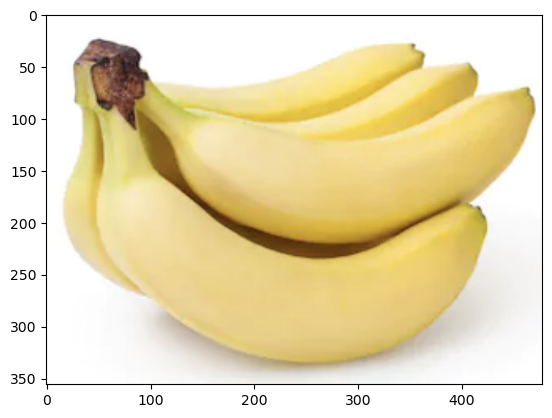

In [29]:
make_predictions('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/Screen Shot 2018-06-12 at 10.05.07 PM.png')

(388, 636, 4)
1/1 [==============================] - 0s 22ms/step


array([[1.]], dtype=float32)

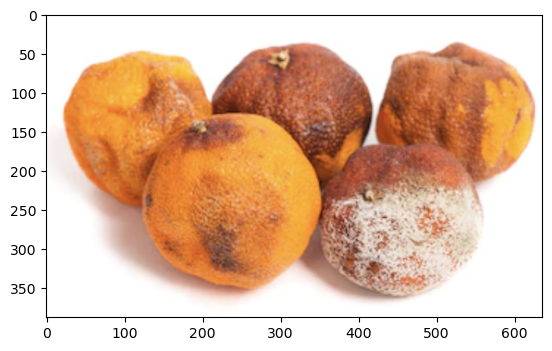

In [30]:
make_predictions('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenoranges/Screen Shot 2018-06-12 at 11.27.01 PM.png')

(358, 352, 4)
1/1 [==============================] - 0s 21ms/step


array([[1.]], dtype=float32)

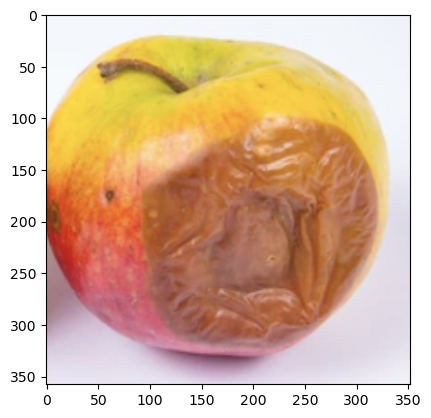

In [31]:
make_predictions('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.44.36 PM.png')

**Because we used Sigmoid activation and judging from the results:**

**Prediction < 0.5 fresh else rotten**

---
# **Making a Helper function**

In [32]:
def fresh_or_rotten(image_path):
    preds = make_predictions(image_path)
    if preds <= 0.5:
        print("\n\nIt's Fresh! eat ahead.\n\n")
    else:
        print("\n\nIt's Rotten, I wont recommend to eat!\n\n")

(1024, 1024, 3)
1/1 [==============================] - 0s 21ms/step


It's Rotten, I wont recommend to eat!




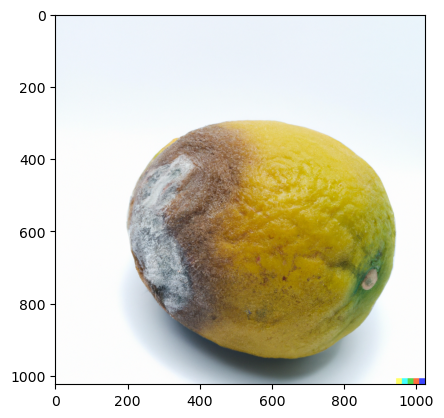

In [33]:
fresh_or_rotten('/kaggle/input/myfruitpictures/rotten_lemon_dalle.png')

(1024, 1024, 3)
1/1 [==============================] - 0s 21ms/step


It's Fresh! eat ahead.




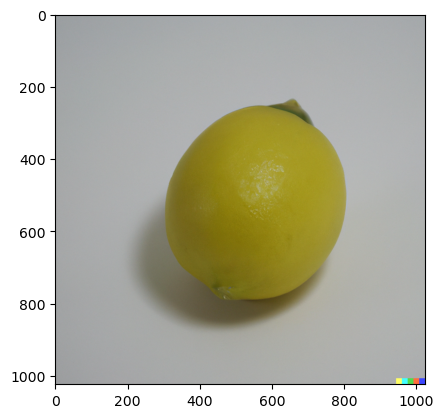

In [34]:
fresh_or_rotten('/kaggle/input/myfruitpictures/fresh_lemon_dalle.png')

(1024, 1024, 3)
1/1 [==============================] - 0s 21ms/step


It's Rotten, I wont recommend to eat!




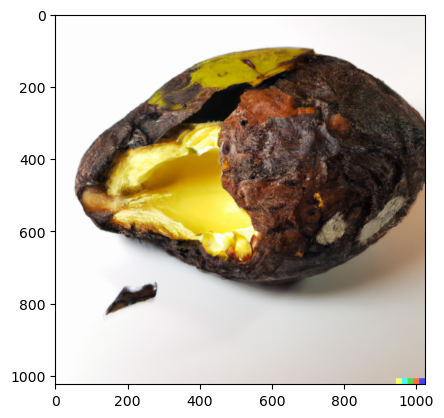

In [35]:
fresh_or_rotten('/kaggle/input/myfruitpictures/rotten_avocado_dalle.png')

(1024, 1024, 3)
1/1 [==============================] - 0s 23ms/step


It's Rotten, I wont recommend to eat!




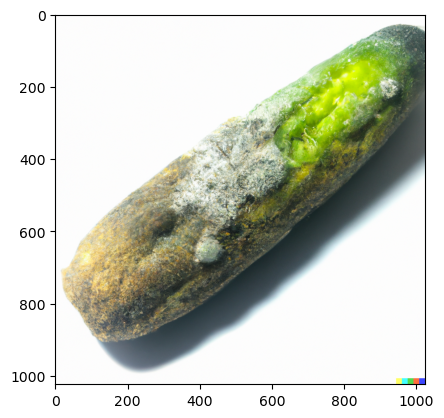

In [36]:
fresh_or_rotten('/kaggle/input/myfruitpictures/rotten_cucumber_dalle.png')

**Now we can see the model could predict rotten or fresh on fruits it have never seen before.**

**The model was trained using only oranges, bananas and apples.**

---
<h3><center><b> Model Architechture </b></center></h3>


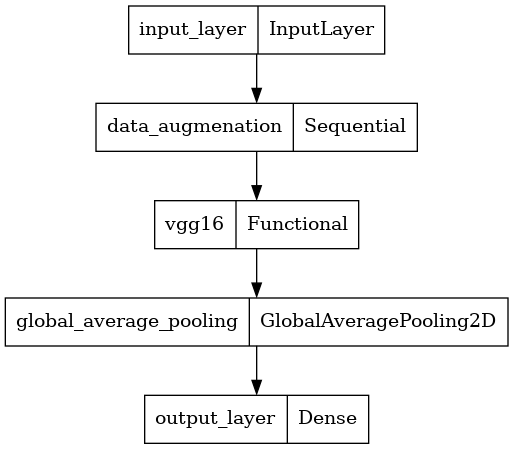

In [37]:
tf.keras.utils.plot_model(
vgg16_rc_model, to_file='vg_rc_model.png',
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

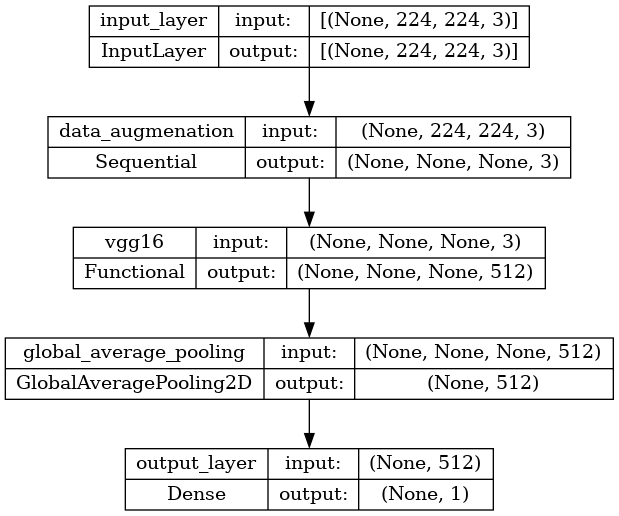

In [38]:
tf.keras.utils.plot_model(
vgg16_rc_model, to_file='vg_rc_s_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [39]:
vgg16_rc_model.save('/kaggle/working/rotten_fruits_classification_model_checkpoint.h5')